In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [16]:
conn = pyodbc.connect("DRIVER={SQL Server};SERVER=LAPTOP-CF4MG3HB\SQLEXPRESS;DATABASE=HealthcareAnalytics;Trusted_Connection=yes")

In [17]:


query = "SELECT * FROM Medicare_Provider_Charge_Inpatient"
Medicare_Provider_Charge_Inpatient = pd.read_sql(query, conn)


C:\Users\hp\AppData\Local\Temp\ipykernel_744\3393417224.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  Medicare_Provider_Charge_Inpatient = pd.read_sql(query, conn)


### Predictive Modelling

In [18]:
Medicare_Provider_Charge_Inpatient.head()

,DRG_Definition,Provider_Id,Provider_Name,Provider_Street_Address,Provider_City,Provider_State,Provider_Zip_Code,Hospital_Referral_Region_HRR_Description,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.078125,5777.241699,4763.736328
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.857422,5787.571289,4976.714355
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.375000,5434.958496,4453.791504
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.280273,5417.560059,4129.160156
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.277344,5658.333496,4851.444336


In [19]:
Medicare_Provider_Charge_Inpatient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 12 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   DRG_Definition                            163065 non-null  object 
 1   Provider_Id                               163065 non-null  int64  
 2   Provider_Name                             163065 non-null  object 
 3   Provider_Street_Address                   163065 non-null  object 
 4   Provider_City                             163065 non-null  object 
 5   Provider_State                            163065 non-null  object 
 6   Provider_Zip_Code                         163065 non-null  int64  
 7   Hospital_Referral_Region_HRR_Description  163065 non-null  object 
 8   Total_Discharges                          163065 non-null  int64  
 9   Average_Covered_Charges                   163065 non-null  float64
 10  Average_Total_Paymen

#### Outlier Treatment

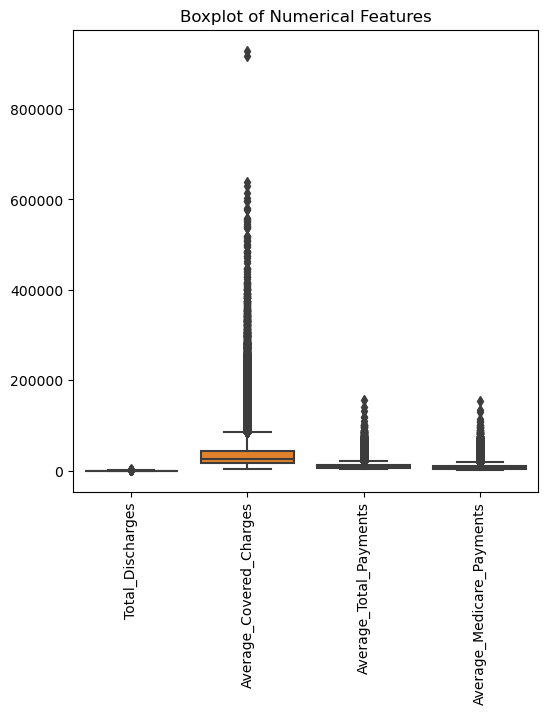

In [20]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=Medicare_Provider_Charge_Inpatient[["Total_Discharges", "Average_Covered_Charges", "Average_Total_Payments", "Average_Medicare_Payments"]])
plt.title("Boxplot of Numerical Features")
plt.xticks(rotation=90)
plt.show()

* Massive outliers in "Average_Covered_Charges" indicate that some providers charge excessively high amounts.
* Payments (Medicare & Total) show controlled variation, implying possible caps on reimbursements despite high covered charges.
* Total Discharges has a few extreme outliers, possibly due to major hospitals or specialized high-volume providers.

In [21]:
num_cols = ["Total_Discharges", "Average_Covered_Charges", "Average_Total_Payments", "Average_Medicare_Payments"]

# Function to detect outliers using IQR
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] < lower_bound) | (data[col] > upper_bound)]

# Print outliers count per column
for col in num_cols:
    outliers = detect_outliers_iqr(Medicare_Provider_Charge_Inpatient, col)
    print(f"{col}: {len(outliers)} outliers detected")


Total_Discharges: 13251 outliers detected
Average_Covered_Charges: 11772 outliers detected
Average_Total_Payments: 11327 outliers detected
Average_Medicare_Payments: 11000 outliers detected


In [22]:
from scipy.stats import mstats

# Apply Winsorization with a 5% cap 
for col in num_cols:
    Medicare_Provider_Charge_Inpatient[col] = mstats.winsorize(
        Medicare_Provider_Charge_Inpatient[col], limits=[0.05, 0.05] 
    )

print("Outliers reduced using 5% Winsorization.")

Outliers reduced using 5% Winsorization.


In [23]:
#Applying log transformation after Winsorization
for col in num_cols:
    Medicare_Provider_Charge_Inpatient[col] = np.log1p(Medicare_Provider_Charge_Inpatient[col])

print("Applied log transformation after Winsorization.")


Applied log transformation after Winsorization.


In [24]:
for col in num_cols:
    outliers = detect_outliers_iqr(Medicare_Provider_Charge_Inpatient, col)
    print(f"{col}: {len(outliers)} outliers detected")

Total_Discharges: 0 outliers detected
Average_Covered_Charges: 0 outliers detected
Average_Total_Payments: 0 outliers detected
Average_Medicare_Payments: 0 outliers detected


C:\Users\hp\Documents\anaconda\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\hp\Documents\anaconda\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\hp\Documents\anaconda\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\hp\Documents\anaconda\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\hp\Documents\anaconda\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\hp\Documents\anaconda\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will

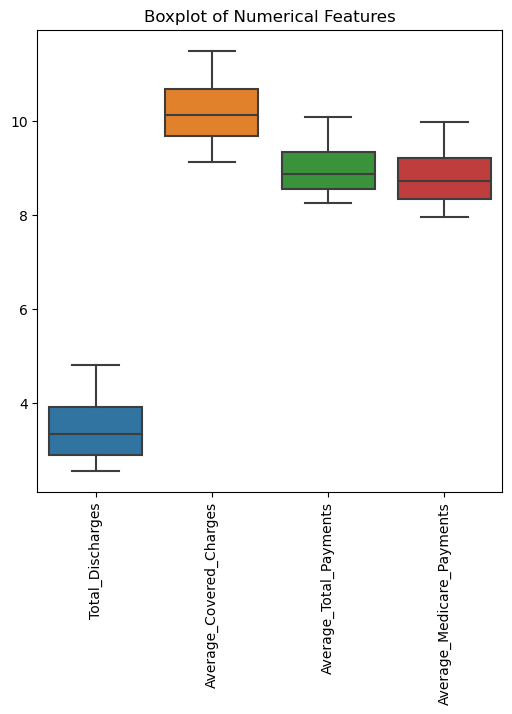

In [25]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=Medicare_Provider_Charge_Inpatient[["Total_Discharges", "Average_Covered_Charges", "Average_Total_Payments", "Average_Medicare_Payments"]])
plt.title("Boxplot of Numerical Features")
plt.xticks(rotation=90)
plt.show()

#### Ordinal Encoding for Categorical Columns

In [26]:

cat_cols = ["DRG_Definition", "Provider_Name", "Provider_Street_Address", "Provider_City", "Provider_State", "Hospital_Referral_Region_HRR_Description"]
encoder = OrdinalEncoder()
Medicare_Provider_Charge_Inpatient[cat_cols] = encoder.fit_transform(Medicare_Provider_Charge_Inpatient[cat_cols])

In [27]:
for col, categories in zip(cat_cols, encoder.categories_):
    print(f"Mapping for {col}:")
    for i, category in enumerate(categories):
        print(f"  {category} -> {i}")

Mapping for DRG_Definition:
  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC -> 0
  057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/O MCC -> 1
  064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION W MCC -> 2
  065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION W CC -> 3
  066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION W/O CC/MCC -> 4
  069 - TRANSIENT ISCHEMIA -> 5
  074 - CRANIAL & PERIPHERAL NERVE DISORDERS W/O MCC -> 6
  101 - SEIZURES W/O MCC -> 7
  149 - DYSEQUILIBRIUM -> 8
  176 - PULMONARY EMBOLISM W/O MCC -> 9
  177 - RESPIRATORY INFECTIONS & INFLAMMATIONS W MCC -> 10
  178 - RESPIRATORY INFECTIONS & INFLAMMATIONS W CC -> 11
  189 - PULMONARY EDEMA & RESPIRATORY FAILURE -> 12
  190 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W MCC -> 13
  191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC -> 14
  192 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W/O CC/MCC -> 15
  193 - SIMPLE PNEUMONIA & PLEURISY W MCC -> 16
  194 - SIMPLE PNEUMONIA & PLEURISY W CC -> 17
  195 - SIMPLE PNEUMONIA & PLEURI

#### Correlation of Features with Target Feature i.e Average_Medicare_Payments

In [28]:
correlation_matrix = Medicare_Provider_Charge_Inpatient.corr()

# Display correlation of all features with 'Average_Medicare_Payments'
print("\nCorrelation with Average_Medicare_Payments:")
print(correlation_matrix["Average_Medicare_Payments"].sort_values(ascending=False))


Correlation with Average_Medicare_Payments:
Average_Medicare_Payments                   1.000000
Average_Total_Payments                      0.987445
Average_Covered_Charges                     0.720789
Provider_Name                               0.034173
Provider_Zip_Code                           0.030362
Provider_Street_Address                     0.006820
Total_Discharges                           -0.001706
Provider_City                              -0.006877
DRG_Definition                             -0.024602
Provider_State                             -0.047742
Provider_Id                                -0.051041
Hospital_Referral_Region_HRR_Description   -0.054596
Name: Average_Medicare_Payments, dtype: float64


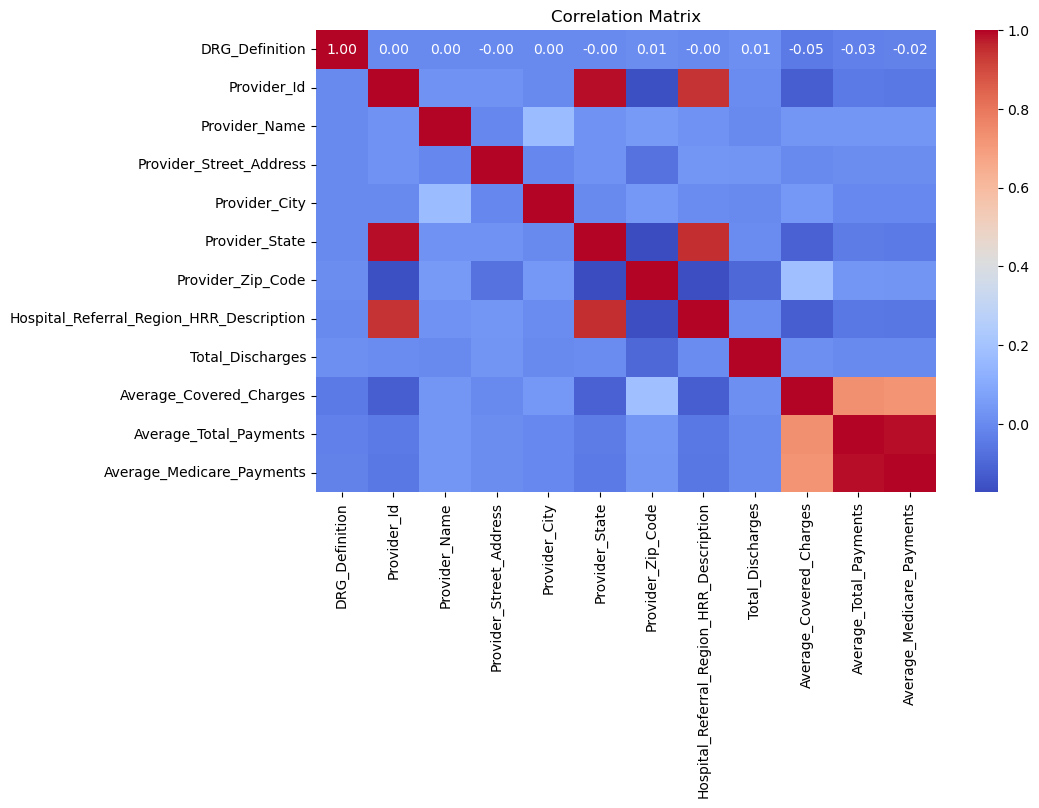

In [29]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### Selecting Features Based on Correlation with Target

In [30]:

selected_features = ["DRG_Definition", "Total_Discharges", "Average_Covered_Charges", "Provider_State", "Hospital_Referral_Region_HRR_Description"]
X_selected = Medicare_Provider_Charge_Inpatient[selected_features]
y = Medicare_Provider_Charge_Inpatient["Average_Medicare_Payments"]

#### Feature Engineering

In [31]:

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_selected)


#### Feature Scaling

In [32]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

#### Split Data

In [33]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


#### LinearRegression

In [34]:

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)


#### LGBMRegressor

In [35]:
!pip install lightgbm
from lightgbm import LGBMRegressor

lgb_reg = LGBMRegressor(
    n_estimators=200,  # Fewer trees
    learning_rate=0.05,  # Slightly higher for faster convergence
    max_depth=6,  # Limits tree depth for speed
    subsample=0.7,  # Uses a subset of data per tree
    colsample_bytree=0.8,  # Uses 80% of features per tree
    random_state=42,
    n_jobs=-1  # Uses all CPU cores
)

lgb_reg.fit(X_train, y_train)
y_pred_lgb = lgb_reg.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4063
[LightGBM] [Info] Number of data points in the train set: 130452, number of used features: 20
[LightGBM] [Info] Start training from score 8.806329


C:\Users\hp\Documents\anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


#### Ridge Regression

In [36]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1.0)  # L2 regularization
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)

#### RandomForestRegressor

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize Random Forest Regressor
rf_reg = RandomForestRegressor(
    n_estimators=100,  
    max_depth=10,  
    min_samples_split=5,  
    n_jobs=-1, 
    random_state=42
)


rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)


#### Evaluate Models

In [38]:

def evaluate_model(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R²: {r2}\n")

In [39]:

evaluate_model(y_test, y_pred_lin, "Linear Regression")


Linear Regression Performance:
MAE: 0.3084223743526412
MSE: 0.14708542900928312
RMSE: 0.3835171821565275
R²: 0.5511027168728218



In [40]:
evaluate_model(y_test, y_pred_lgb, "LGBMRegressor")


LGBMRegressor Performance:
MAE: 0.1560407253047916
MSE: 0.04070258736410227
RMSE: 0.20174882246026188
R²: 0.8757777639358215



In [41]:
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")


Ridge Regression Performance:
MAE: 0.3084385336900358
MSE: 0.14708364587316286
RMSE: 0.383514857434706
R²: 0.5511081589139893



In [42]:
evaluate_model(y_test, y_pred_rf, "Optimized Random Forest")

Optimized Random Forest Performance:
MAE: 0.21490019016058717
MSE: 0.07839696010405035
RMSE: 0.2799945715617543
R²: 0.7607364466135059



In [43]:
import pickle

with open("C:/Users/hp/Documents/y_pred_lgb.pkl", "wb") as file:
    pickle.dump(y_pred_lgb, file)
    
print("Model saved as y_pred_lgb.pkl")

Model saved as y_pred_lgb.pkl
